In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [2]:
from functools import partial

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [5]:
from deepspeech.model import DeepSpeech
from deepspeech.model import SequenceWise
from deepspeech.data.data_loader import SpectrogramParser
from deepspeech.data.data_loader import BucketingSampler

/home/nemo/envs/noswear/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [7]:
from noswear.data import dataset
from noswear.utils import RNNValueExtractor
from noswear.utils import Identity
from noswear.utils import bucketing_dataloader
from noswear.utils import filter_low_count_words
from noswear.layers import ResidualRNN

We are building upon DeepSpeech CNN layers.

In [8]:
base_model = DeepSpeech.load_model(
    '../models/librispeech_pretrained.pth'
)
audio_conf = DeepSpeech.get_audio_conf(base_model)
parser = SpectrogramParser(audio_conf, normalize=True)

We have our own swear/non-swear data, load it.

In [9]:
ds_swear = dataset.SwearDataset(base_path='../', providers=dataset.DEFAULT_PROVIDERS)

In [10]:
X_swear, y_swear = ds_swear.load()

In [11]:
ds = dataset.SwearBinaryAudioDataset(X_swear, y_swear, parser)

In [12]:
X, y = ds.load()

In [13]:
seq_lens = np.array([x.shape[1] for x in X])
max_seq_len = max(seq_lens)
max_seq_len, np.mean(seq_lens), np.median(seq_lens)

(663, 238.64055299539172, 173.0)

In [14]:
X_pad = np.zeros(
    (len(X), X[0].shape[0], max_seq_len), 
    dtype='float32'
)
for i, _ in enumerate(X):
    X_pad[i, :, :seq_lens[i]] = X[i]
    
y = np.array(y)

Filter low count words

In [15]:
idcs = filter_low_count_words(X_swear, min_count=4)
X_pad = X_pad[idcs]
y = y[idcs]

Splitting into train/valid/test

In [16]:
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [17]:
# use word as class for stratified split to make sure that train/test
# set both contain examples of the all words.
y_word = np.array([n[0] for n in X_swear])[idcs]
train_idcs_proto, test_idcs = next(split.split(y, y=y_word))

/home/nemo/envs/noswear/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [18]:
train_idcs, valid_idcs = next(split.split(y[train_idcs_proto], y=y_word[train_idcs_proto]))

/home/nemo/envs/noswear/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [19]:
train_idcs = train_idcs_proto[train_idcs]
valid_idcs = train_idcs_proto[valid_idcs]

Plot the class distribution (words)

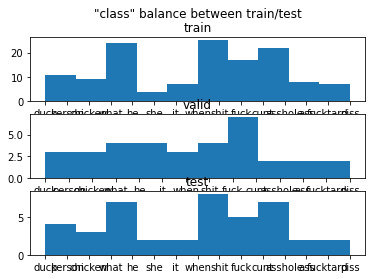

In [20]:
plt.subplot(311)
plt.title('"class" balance between train/test\ntrain')
plt.hist(y_word[train_idcs]);
plt.subplot(312)
plt.title('valid')
plt.hist(y_word[valid_idcs]);
plt.subplot(313)
plt.title('test')
plt.hist(y_word[test_idcs]);

In [21]:
X_train = {'lens': seq_lens[train_idcs], 'X': X_pad[train_idcs]}
y_train = np.array(y)[train_idcs].astype('float32')

X_valid = {'lens': seq_lens[valid_idcs], 'X': X_pad[valid_idcs]}
y_valid = np.array(y)[valid_idcs].astype('float32')

X_test = {'lens': seq_lens[test_idcs], 'X': X_pad[test_idcs]}
y_test = np.array(y)[test_idcs].astype('float32')

In [22]:
len(X_train['X']), len(X_valid['X']), len(X_test['X'])

(134, 34, 42)

Check if train/valid/test are balanced ($y \approx 0.5$)

In [23]:
y_train.mean(), y_valid.mean(), y_test.mean()

(0.51492536, 0.5, 0.5)

Model definition

In [90]:
class NoSwearModel(torch.nn.Module):
    def __init__(
        self, 
        base_model, 
        n_hidden=10, 
        n_layers=1,
        p_dropout=0.2,
        selector='last',
    ):
        super().__init__()
        self.base_model = base_model
        self.base_model.rnns = Identity()
        self.base_model.lookahead = Identity()
        self.base_model.fc = Identity()
        self.base_model.inference_softmax = Identity()
        
        self.selector = selector
        
        self.rnn = torch.nn.Sequential(
            torch.nn.LSTM(672, n_hidden, num_layers=n_layers, bias=False, batch_first=True),
            RNNValueExtractor(),
        )

        self.clf = torch.nn.Linear(n_hidden, 1, bias=False)
        self.dropout = torch.nn.Dropout(p=p_dropout)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.rnn[0].reset_parameters()
        self.clf.reset_parameters()
        
    def forward(self, X, lens):
        # run base model, output is NxTxH with
        # T=Time, N=samples, H=hidden.
        y_pre = self.base_model(X)
        y_pre = self.dropout(y_pre)
        
        # run RNN over sequence and extract last item
        y = self.rnn(y_pre)
        
        if self.selector == 'designated':
            # instead of taking element -1 we just
            # designate neuron 0 to be our confidence indicator;
            # we take the element where [0] is greatest.
            indicator = y[:, :, 0]
            idcs_time = indicator.argmax(axis=-1)
            idcs_batch = list(range(X.shape[0]))

            # index using (batch, time) tuples        
            y = y[idcs_batch, idcs_time, :]
        else:
            y = y[:, -1]
            
        y = self.clf(y)        
        return y, indicator[idcs_batch, idcs_time], indicator

Training loop and stuff

In [91]:
def bucket(Xi, yi):
    Xi['X'] = Xi['X'][:, :, :max(Xi['lens'])]
    return Xi, yi

In [92]:
class BinaryClassifier(skorch.classifier.NeuralNetBinaryClassifier):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        return super().get_loss(y_pred[0], y_true, *args, **kwargs)

In [93]:
torch.manual_seed(42)

net = BinaryClassifier(
    partial(NoSwearModel, base_model), 
    
    iterator_train=bucketing_dataloader,
    iterator_train__bucket_fn=bucket,
    iterator_train__shuffle=True,
    iterator_valid=bucketing_dataloader,
    iterator_valid__bucket_fn=bucket,
    
    batch_size=4,
    max_epochs=30,
    device='cuda',
    
    train_split=predefined_split(Dataset(X_valid, y_valid)),
    
    module__p_dropout=0.0,
    module__n_hidden=32,
    module__n_layers=1,
    module__selector='designated',
        
    optimizer=torch.optim.Adam,
    optimizer__lr=0.0004,
    
    callbacks=[
        skorch.callbacks.Freezer('base_model.*'),
        skorch.callbacks.Checkpoint(monitor='valid_acc_best'),
        #skorch.callbacks.TrainEndCheckpoint(),
    ]
)

In [94]:
%pdb on
net.fit(X_train, y_train)

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6998       0.5294        0.6822     +  1.4913
      2        0.6842       0.4706        0.6795        1.3712
      3        0.6593       0.5000        0.6728        1.4444
      4        0.6564       0.5294        0.6782        1.3772
      5        0.6361       0.6471        0.6484     +  1.3359
      6        0.6216       0.6765        0.6324     +  1.4685
      7        0.6090       0.6176        0.6525        1.4964
      8        0.6253       0.6765        0.6334        1.3671
      9        0.6089       0.5882        0.6209        1.3571
     10        0.5789       0.6765        0.5850        1.5273
     11        0.5864       0.7647        0.5574     +  1.7596
     12        0.5595       0.7941        0.5292     +  1.5183
     13        0.5380       0.7059        0.5569        1.4164
     14       

<class '__main__.BinaryClassifier'>[initialized](
  module_=NoSwearModel(
    (base_model): DeepSpeech(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0, max_val=20, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardtanh(min_val=0, max_val=20, inplace=True)
      )
      (rnns): Identity()
      (fc): Identity()
      (inference_softmax): Identity()
      (lookahead): Identity()
    )
    (rnn): Sequential(
      (0): LSTM(672, 32, bias=False, batch_first=True)
      (1): RNNValueExtractor()
    )
    (clf): Linear(in_features=32, out_features=1, bias=False)
    (dropout): Dropout(p=0.0, inplace=False)
  ),
)

Training done, let's look at the accuracy of the best net (via valid loss)

In [95]:
net.load_params(checkpoint=dict(net.callbacks_)['Checkpoint'])

In [96]:
accuracy_score(y_test, net.predict(X_test))

0.8571428571428571

In [97]:
accuracy_score(y_valid, net.predict(X_valid))

0.9117647058823529

Let's inspect the indicator neuron (what does it do)

In [98]:
outputs = list(net.forward_iter(X_valid))

It seems to strongly, inversely correlate with the predicted output class

In [112]:
class_log, indicator_log, indicator_sequence_log = zip(*outputs)
class_log = torch.cat(class_log)
indicator_log = torch.cat(indicator_log)

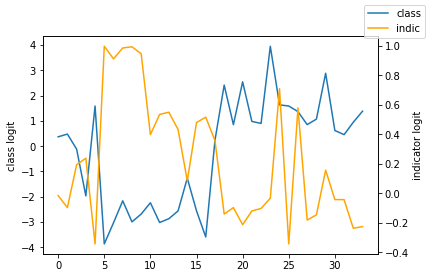

In [103]:
plt.plot(class_log)
plt.ylabel('class logit')

ax = plt.twinx()
ax.plot(indicator_log, c='orange')
plt.ylabel('indicator logit')

plt.gcf().legend(['class', 'indic']);

How does it evolve in time?

In [141]:
# since we have batched processing, we remove the batch dimension
# outputs.shape = (len(X_valid), 4, ?) => (len(X_valid), 4*?)
def debatch_indicator_sequences(outputs):
    def a():
        for _, _, indicator_seqs in outputs:
            for seq in indicator_seqs:
                yield seq
    return list(a())

In [147]:
indicator_sequences = debatch_indicator_sequences(outputs)

In [231]:
def plot_seq_base(indicator_sequence, clogit, fpath):
    swear = clogit >= 0.5
    title = f"{fpath} - swear: {swear}"
    
    plt.title(title)
    plt.plot(indicator_sequence)
    plt.legend(['indic. neuron'])
    
def plot_seq(i):
    sequence = indicator_sequences[i]
    clogit = class_log[i]
    fpath = np.array(X_swear)[valid_idcs][i][1]
    
    plot_seq_base(sequence, clogit, fpath)

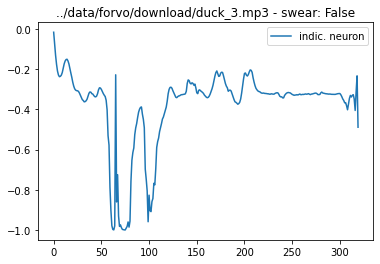

In [232]:
plot_seq(0)

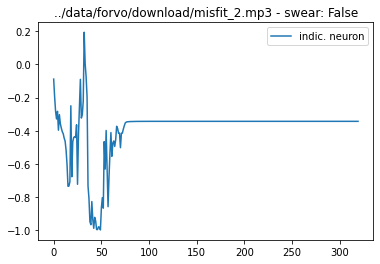

In [169]:
plot_seq(2)

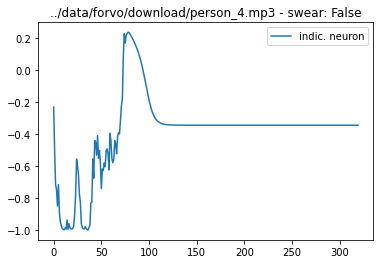

In [170]:
plot_seq(3)

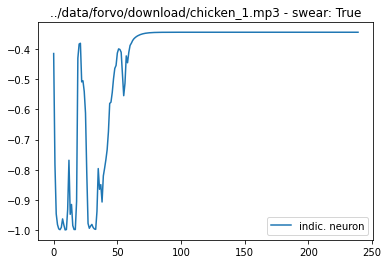

In [171]:
plot_seq(4)

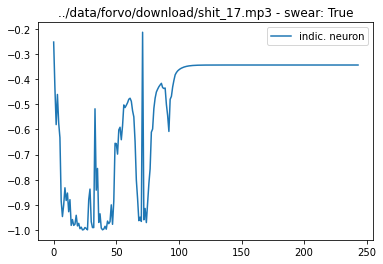

In [177]:
plot_seq(20)

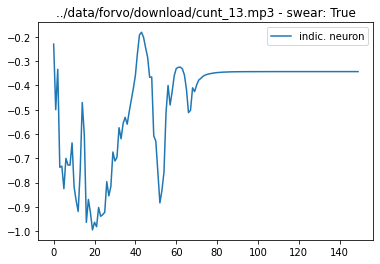

In [242]:
plot_seq(27)

Test on a single sample, a long-stretched 'shiiit'

In [201]:
audio_inp = parser.parse_audio('../data/own/shiiiit.ogg')
inp = {'X': audio_inp[None], 'lens': np.array([audio_inp.shape[1]])}

In [210]:
c, i, ics = zip(*list(net.forward_iter(inp)))

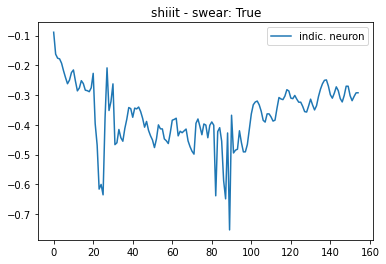

In [235]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit')

### grid search



In [ ]:
from sklearn.model_selection import GridSearchCV
from skorch.helper import SliceDict

In [ ]:
#net.initialize();
net.set_params(verbose=False);

In [ ]:
params = {
    'optimizer__lr': [0.02, 0.002, 0.0002],
    'optimizer__weight_decay': [0, 1e-4],
    'optimizer': [torch.optim.RMSprop, torch.optim.Adam],
    'module__p_dropout': [0, 0.5],
    'module__n_hidden': [10, 100, 200, 400],
    'module__n_layer': [1, 2],
}

In [ ]:
cv = TODO

In [ ]:
gs = GridSearchCV(net, params, scoring='accuracy', cv=cv)

In [ ]:
%%time
gs.fit(SliceDict(**X_train), y_train);

In [ ]:
import pandas as pd
results = pd.DataFrame(gs.cv_results_)

In [ ]:
top_results = results.sort_values(by='mean_test_score').head(10)

In [ ]:
top_results

In [ ]:
top_results.params

In [ ]:
net.set_params(verbose=True, **top_results.params.iloc[1]);

In [ ]:
net.fit(X_train, y_train);

In [ ]:
accuracy_score(y_test, net.predict(X_test))